# Base model

## library import

In [4]:
from functools import reduce
import time
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchsummary import summary as summary_

In [ ]:
torch.__version__

## Data load

In [5]:
train_data = datasets.MNIST(root='./', train=True, download=False, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./ ', train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=64, shuffle=True)

### 레이어 정의 함수

In [6]:
import collections

def set_layer(
        in_channels,
        out_channels,
        kernel_size,
        set_weight,
        set_bias,
        name=''):

    m = nn.Conv2d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding='same',
                  stride=1)

    m.weight = nn.Parameter(set_weight)
    m.bias = nn.Parameter(set_bias)
    return m

def cnn_layer_x(in_channel,
                out_channel,
                kernel_size,
                weight,
                bias):
    return nn.Sequential(
        collections.OrderedDict(
            [
                ('conv', set_layer(in_channel, out_channel, kernel_size,
                                 set_weight   = weight,
                                 set_bias     = bias)),
                ('relu'    , nn.ReLU(inplace=True)),
                ('max_pool', nn.MaxPool2d(2))
            ]
        )
    )

### 베이스 모델 정의

-1
    - conv(in=1, out=4)
    - maxpool(size=2)
    - relu()

-2
    - conv(in=4, out=8)
    - maxpool(size=2)
    - relu()

-3
    - conv(in=8, out=16)
    - maxpool(size=2)
    - relu()

-4
    - flattern()
    - Linear(144, 100)
    - Relu()
    - Linear(100, 10)
    - softmax()


In [7]:
def define_model(in_channel, input_shape, out_classes):
    div_list = lambda x: x // 2

    out_channel = 4
    kernel_size = 3

    layer_1_weight = torch.normal(0, 0.01,
                                  size=(out_channel,
                                        in_channel,
                                        kernel_size,
                                        kernel_size))
    layer_1_bias=torch.zeros(out_channel)

    features_layer_one = cnn_layer_x(in_channel,
                                     out_channel,
                                     kernel_size,
                                     layer_1_weight,
                                     layer_1_bias)
    output_shape = list(map(div_list, input_shape))

    in_channel = out_channel
    out_channel = 8
    kernel_size = 3

    layer_2_weight = torch.normal(0, 0.01,
                                  size=(out_channel,
                                        in_channel,
                                        kernel_size,
                                        kernel_size))
    layer_2_bias=torch.zeros(out_channel)

    features_layer_two = cnn_layer_x(in_channel,
                                     out_channel,
                                     kernel_size,
                                     layer_2_weight,
                                     layer_2_bias)

    output_shape = list(map(div_list, output_shape))

    in_channel = out_channel
    out_channel = 16
    kernel_size = 3

    layer_3_weight = torch.normal(0, 0.01,
                                  size=(out_channel,
                                        in_channel,
                                        kernel_size,
                                        kernel_size))
    layer_3_bias=torch.zeros(out_channel)

    features_layer_three = cnn_layer_x(in_channel,
                                       out_channel,
                                       kernel_size,
                                       layer_3_weight,
                                       layer_3_bias)

    output_shape = list(map(div_list, output_shape))

    feature_extraction_layers_ = nn.Sequential(
        collections.OrderedDict([
            ('layer1', features_layer_one),
            ('layer2', features_layer_two),
            ('layer3', features_layer_three)
        ])
    )

    out_channel = reduce(lambda res, element: res*element, output_shape) * out_channel

    classifier = nn.Sequential(
        collections.OrderedDict([
            ('flatten',     nn.Flatten()),
            ('in_linear',   nn.Linear(out_channel, out_channel // 2)),
            ('relu',        nn.ReLU(inplace=True)),
            ('out_linear',  nn.Linear(out_channel // 2, out_classes)),
            ('output',      nn.Softmax(dim=0)),
        ]),
    )

    model = nn.Sequential(
        collections.OrderedDict(
            [
                ('feature_extractor', feature_extraction_layers_),
                ('classifier', classifier)
            ]
        )
    )

    return model

## Training Loop

In [4]:
def training_loop(model, dataloader, epochs, device='mps'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.CrossEntropyLoss()

    accuracy = Accuracy(threshold=0.5).to(device)

    step_accuracy = 0.0
    step_loss = 0.0
    step = 0

    # traning loop
    with tqdm(total=epochs * len(dataloader)) as pbar:
        for epoch in range(epochs):
            for data, target in dataloader:
                data = data.to(device)
                target = target.to(device)

                optimizer.zero_grad()
                hyphothesis = model(data)
                loss = criterion(hyphothesis, target)

                loss.backward()
                optimizer.step()

                step_loss += loss.item()
                step_accuracy += accuracy(hyphothesis, target)

                if step % (len(dataloader) // 10) == 0:
                    pbar.set_description(f'epoch: {epoch + 1}, step: {step + 1}, Acc: {step_accuracy / (step+1)}, loss: {step_loss / (step+1)}')
                    step_loss = 0.0

                pbar.update(1)
                step += 1

    return {
        'acc': step_accuracy / step,
        'loss': step_loss / step
    }

아래 부분은 base model 학습 후 저장하는 코드임
이미 학습을 했다면 재학습을 하지 않아도 됨

In [ ]:
model = define_model(3, [32, 32], 100)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

summary_(model, (3, 32, 32))

# train_data = datasets.MNIST(root='./mnist', train=True, download=False, transform=transforms.ToTensor())
# test_data = datasets.MNIST(root='./mnist', train=False, transform=transforms.ToTensor())

train_data = datasets.CIFAR100(root='./cifar100', train=True, download=False, transform=transforms.ToTensor())
test_data = datasets.CIFAR100(root='./cifar100', train=False, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=64, shuffle=True)

acc, loss = training_loop(model, train_dataloader, 50, 'cpu')

# 가중치 초기화는 random value로 함 (standard)
torch.save({
    "model": model,
    "epochs": 50,
    "batch_size": 64,
    'accuracy': acc,
    "loss": loss}, './compressed_base_model_weight_cifar100.pt')

In [53]:
train_data = datasets.CIFAR100(root='./cifar100', train=True, download=False, transform=transforms.ToTensor())
test_data = datasets.CIFAR100(root='./cifar100', train=False, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=64, shuffle=True)

## Test code

In [8]:
def eval_loop(model, dataloader):
    # evaluation 할때
    model.eval()
    model.to('cpu')
    accuracy = Accuracy(threshold=0.5, num_classes=10)

    tot_acc = 0.0

    for data, target in dataloader:
        data = data.to('cpu')
        target = target.to('cpu')
        res = model(data)

        # 0~10으로 분류함
        probabilty, predicted = torch.max(res, 1)

        # mini batch의 정확도
        tot_acc += accuracy(predicted, target)

    return tot_acc / len(dataloader)

# 학습된 모델 로딩

In [6]:
model = torch.load('./compressed_base_model_weight.pt')['model']

# 실험. 1~N개를 선택하는데 모두 시도하여 정확도를 찾음

## Layer 1 (1->4)에서 feature를 선택하며 가장 정확도가 높은 조합을 찾음

In [ ]:
import itertools
layer_idx = [0, 1, 2, 3]

in_channel_one = 1
kernel_size = 3
device = "cpu"

idx = 1
time_arr = np.zeros(shape=(16,))
acc_arr = np.zeros(shape=(16,))

out_feature = 4

with tqdm(total = 2 ** out_feature - 1) as pbar:
    for selector in [1, 2, 3, 4]:
        for comb in itertools.combinations(layer_idx, selector):
            torch.manual_seed(888)
            np.random.seed(888)
            random.seed(888)

            # find layer 1 best feature
            weight = model.feature_extractor.layer1.conv.weight.to(device)[list(comb)]
            bias   = model.feature_extractor.layer1.conv.bias.to(device)[list(comb)]

            if weight.dim == 3:
                weight = weight.unsqueeze(dim=0)
                bias = bias.unsqueeze(dim=0)

            layer_1 = cnn_layer_x(in_channel_one, selector, kernel_size, weight, bias)
            layer_2 = cnn_layer_x(selector, 8, kernel_size,
                                  model.feature_extractor.layer2.conv.weight.to(device)[:, list(comb)],
                                  model.feature_extractor.layer2.conv.bias.to(device))
            layer_3 = cnn_layer_x(8, 16, kernel_size,
                                  model.feature_extractor.layer3.conv.weight.to(device),
                                  model.feature_extractor.layer3.conv.bias.to(device))

            modified_model = nn.Sequential(layer_1, layer_2, layer_3, model.classifier)

            start = time.perf_counter()
            res = eval_loop(modified_model, train_dataloader)
            end = time.perf_counter()

            time_arr[idx] = end - start
            acc_arr[idx] = res.detach()
            idx += 1
            pbar.update(1)
            pbar.set_description(f'layer: {bin(idx)}, time: {end - start}, acc: {res.detach()}')

In [ ]:
time_arr

In [ ]:
acc_arr

## Layer 2 (4->8)에서 feature를 선택하며 가장 정확도가 높은 조합을 찾음

In [ ]:
import itertools
layer_idx = [0, 1, 2, 3, 4, 5, 6, 7]

in_channel_one = 1
kernel_size = 3
device = "cpu"

idx = 1
out_feature = 8

time_arr = np.zeros(shape=(2**8,))
acc_arr = np.zeros(shape=(2**8,))

with tqdm(total = 2 ** out_feature - 1) as pbar:
    for selector in list(map(lambda x: x+1, layer_idx)):
        for comb in itertools.combinations(layer_idx, selector):
            torch.manual_seed(888)
            np.random.seed(888)
            random.seed(888)

            # find layer 2 best feature
            weight = model.feature_extractor.layer2.conv.weight.to(device)[list(comb)]
            bias   = model.feature_extractor.layer2.conv.bias.to(device)[list(comb)]

            layer_1 = cnn_layer_x(1, 4, kernel_size,
                                  model.feature_extractor.layer1.conv.weight.to(device),
                                  model.feature_extractor.layer1.conv.bias.to(device))
            layer_2 = cnn_layer_x(4, selector, kernel_size,
                                  weight,
                                  bias)
            layer_3 = cnn_layer_x(selector, 16, kernel_size,
                                  model.feature_extractor.layer3.conv.weight.to(device)[:, list(comb)],
                                  model.feature_extractor.layer3.conv.bias.to(device))

            modified_model = nn.Sequential(layer_1, layer_2, layer_3, model.classifier)

            start = time.perf_counter()
            res = eval_loop(modified_model, train_dataloader)
            end = time.perf_counter()

            time_arr[idx] = end - start
            acc_arr[idx] = res.detach()
            idx += 1
            pbar.update(1)
            pbar.set_description(f'layer: {bin(idx)}, time: {end - start}, acc: {res.detach()}')

## Layer 3 (8->16)에서 feature를 선택하며 가장 정확도가 높은 조합을 찾음

In [ ]:
import itertools
layer_idx = list(range(16))

in_channel_one = 1
kernel_size = 3
device = "cpu"

idx = 256
out_feature = len(layer_idx)

time_arr = np.zeros(shape=(2**out_feature,))
acc_arr = np.zeros(shape=(2**out_feature,))

with tqdm(total = 2 ** out_feature - len(bin(idx))-2 - 1) as pbar:
    for selector in list(map(lambda x: x+1, layer_idx)):
        for comb in list(itertools.combinations(layer_idx, selector))[idx:]:
            torch.manual_seed(888)
            np.random.seed(888)
            random.seed(888)

            # find layer 2 best feature
            weight = model.feature_extractor.layer3.conv.weight.to(device)[list(comb)]
            bias   = model.feature_extractor.layer3.conv.bias.to(device)[list(comb)]

            layer_1 = cnn_layer_x(1, 4, kernel_size,
                                  model.feature_extractor.layer1.conv.weight.to(device),
                                  model.feature_extractor.layer1.conv.bias.to(device))
            layer_2 = cnn_layer_x(4, 8, kernel_size,
                                  model.feature_extractor.layer2.conv.weight.to(device),
                                  model.feature_extractor.layer2.conv.bias.to(device))
            layer_3 = cnn_layer_x(8, selector, kernel_size,
                                  weight,
                                  bias)

            res_flatten_idx = list(reduce(lambda res, e: res + e, map(lambda x: [i + (3*3)*x for i in range(3*3)], comb)))

            linear_weight = model.classifier.in_linear.weight[:, res_flatten_idx]
            linear_bias = model.classifier.in_linear.bias

            classifier = nn.Sequential(
                collections.OrderedDict([
                    ('flatten', nn.Flatten()),
                    ('in_linear', nn.Linear(selector * 3 * 3, 100)),
                    ('relu', nn.ReLU(inplace=True)),
                    ('out_linear', nn.Linear(100, 10)),
                    ('output', nn.Softmax(dim=0))
                ])
            )

            classifier.in_linear.weight = nn.Parameter(linear_weight)
            classifier.in_linear.bias = nn.Parameter(linear_bias)

            modified_model = nn.Sequential(layer_1, layer_2, layer_3, classifier)

            # 144 -> 16 * 3 * 3
            # 72  -> 8 * 3 * 3

            start = time.perf_counter()
            res = eval_loop(modified_model, train_dataloader)
            end = time.perf_counter()

            time_arr[idx] = end - start
            acc_arr[idx] = res.detach()
            idx += 1
            pbar.update(1)
            pbar.set_description(f'layer: {bin(idx).replace("0b", "").zfill(out_feature)}, time: {end - start}, acc: {res.detach()}')

# 실험. 2 1 ~ N개를 선택하는데 빠르게 찾기

In [ ]:
import itertools


'''
    find_layer_n_best_feature(model_weights, model_feature_selection) -> best_feature_combinations
'''

In [127]:
model

Sequential(
  (feature_extractor): Sequential(
    (layer1): Sequential(
      (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (relu): ReLU(inplace=True)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (relu): ReLU(inplace=True)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (relu): ReLU(inplace=True)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (in_linear): Linear(in_features=144, out_features=100, bias=True)
    (relu): ReLU(inplace=True)
    (out_linear): Linear(in_features=100, out_features=10, bias=True)

In [7]:
eval_loop(model, train_dataloader)

tensor(0.9817)

In [7]:
def layer_1_define(comb):
        torch.manual_seed(888)
        np.random.seed(888)
        random.seed(888)

        # find layer 1 best feature
        weight = model.feature_extractor.layer1.conv.weight.to(device)[list(comb)]
        bias   = model.feature_extractor.layer1.conv.bias.to(device)[list(comb)]

        if weight.dim == 3:
            weight = weight.unsqueeze(dim=0)
            bias = bias.unsqueeze(dim=0)

        layer_1 = cnn_layer_x(in_channel_one, len(comb), kernel_size, weight, bias)
        layer_2 = cnn_layer_x(len(comb), 8, kernel_size,
                              model.feature_extractor.layer2.conv.weight.to(device)[:, list(comb)],
                              model.feature_extractor.layer2.conv.bias.to(device))
        layer_3 = cnn_layer_x(8, 16, kernel_size,
                              model.feature_extractor.layer3.conv.weight.to(device),
                              model.feature_extractor.layer3.conv.bias.to(device))

        params_size = 1 * len(comb) * 3 * 3 + len(comb) + 4*8*3*3+4+8*16*3*3+8 + 144*100+100 + 100*10+10

        modified_model = nn.Sequential(layer_1, layer_2, layer_3, model.classifier)

        start = time.perf_counter()
        res = eval_loop(modified_model, train_dataloader)
        end = time.perf_counter()

        return end - start, res.detach().cpu().numpy().tolist(), params_size

In [8]:
in_channel_one = 1
kernel_size = 3
device = "cpu"

def layer_2_define(comb):
    torch.manual_seed(888)
    np.random.seed(888)
    random.seed(888)

        # find layer 2 best feature
    selector = len(comb)

    layer_1 = cnn_layer_x(1, 4, kernel_size,
                          model.feature_extractor.layer1.conv.weight.to(device),
                          model.feature_extractor.layer1.conv.bias.to(device))
    layer_2 = cnn_layer_x(4, selector, kernel_size,
                          model.feature_extractor.layer2.conv.weight.to(device)[list(comb)],
                          model.feature_extractor.layer2.conv.bias.to(device)[list(comb)])
    layer_3 = cnn_layer_x(selector, 16, kernel_size,
                          model.feature_extractor.layer3.conv.weight.to(device)[:, list(comb)],
                          model.feature_extractor.layer3.conv.bias.to(device))


    params_size = 1*4*3*3+4 + 4*selector*3*3+8 + selector*16*3*3+8 + 16*3*3*100+100 + 100*10+10

    modified_model = nn.Sequential(layer_1, layer_2, layer_3, model.classifier)

    start = time.perf_counter()
    res = eval_loop(modified_model, train_dataloader)
    end = time.perf_counter()

    return end - start, res.detach().cpu().numpy().tolist(), params_size

In [9]:
def layer_3_define(comb):
    torch.manual_seed(888)
    np.random.seed(888)
    random.seed(888)

    selector = len(comb)
    layer_1 = cnn_layer_x(1, 4, kernel_size,
                          model.feature_extractor.layer1.conv.weight.to(device),
                          model.feature_extractor.layer1.conv.bias.to(device))
    layer_2 = cnn_layer_x(4, 8, kernel_size,
                          model.feature_extractor.layer2.conv.weight.to(device),
                          model.feature_extractor.layer2.conv.bias.to(device))

    weight = model.feature_extractor.layer3.conv.weight.to(device)[comb]
    bias   = model.feature_extractor.layer3.conv.bias.to(device)[comb]
    layer_3 = cnn_layer_x(8, selector, kernel_size,
                          weight,
                          bias)

    res_flatten_idx = list(reduce(lambda res, e: res + e,
                                  map(lambda x: [i + (3 * 3) * x for i in range(3 * 3)], comb)))

    params_size = 1*4*3*3+4 + 4*8*3*3+8 + 8*selector*3*3+selector + len(res_flatten_idx)*100+100 + 100*10+10

    linear_weight = model.classifier.in_linear.weight[:, res_flatten_idx]
    linear_bias = model.classifier.in_linear.bias

    classifier = nn.Sequential(
        collections.OrderedDict([
            ('flatten', nn.Flatten()),
            ('in_linear', nn.Linear(selector * 3 * 3, 100)),
            ('relu', nn.ReLU(inplace=True)),
            ('out_linear', nn.Linear(100, 10)),
            ('output', nn.Softmax(dim=0))
        ])
    )

    classifier.in_linear.weight = nn.Parameter(linear_weight)
    classifier.in_linear.bias = nn.Parameter(linear_bias)
    classifier.out_linear.weight = nn.Parameter(model.classifier.out_linear.weight)
    classifier.out_linear.bias = nn.Parameter(model.classifier.out_linear.bias)

    modified_model = nn.Sequential(layer_1, layer_2, layer_3, classifier)
    start = time.perf_counter()
    res = eval_loop(modified_model, train_dataloader)
    end = time.perf_counter()

    return end - start, res.detach().cpu().numpy().tolist(), params_size

In [10]:
def layer_3_define_ordered(comb):
    torch.manual_seed(888)
    np.random.seed(888)
    random.seed(888)

    selector = len(comb)
    layer_1 = cnn_layer_x(1, 4, kernel_size,
                          model.feature_extractor.layer1.conv.weight.to(device),
                          model.feature_extractor.layer1.conv.bias.to(device))
    layer_2 = cnn_layer_x(4, 8, kernel_size,
                          model.feature_extractor.layer2.conv.weight.to(device),
                          model.feature_extractor.layer2.conv.bias.to(device))

    weight = torch.tensor([])
    bias = torch.tensor([])
    for c in comb:
        weight = torch.concat([weight, model.feature_extractor.layer3.conv.weight.to(device)[c][np.newaxis]], dim=0)
        bias  = torch.concat([bias, model.feature_extractor.layer3.conv.bias.to(device)[c][np.newaxis]], dim=0)

    layer_3 = cnn_layer_x(8, selector, kernel_size,
                          weight,
                          bias)

    res_flatten_idx = list(reduce(lambda res, e: res + e,
                                  map(lambda x: [i + (3 * 3) * x for i in range(3 * 3)], comb)))

    linear_weight = torch.tensor([])
    linear_bias = model.classifier.in_linear.bias

    for res_flat in map(lambda x: [i + (3 * 3) * x for i in range(3 * 3)], comb):
        linear_weight = torch.concat([linear_weight, model.classifier.in_linear.weight[:, res_flat]], dim=1)

    print(linear_weight.shape)

    params_size = 1*4*3*3+4 + 4*8*3*3+8 + 8*selector*3*3+selector + len(res_flatten_idx)*100+100 + 100*10+10

    classifier = nn.Sequential(
        collections.OrderedDict([
            ('flatten', nn.Flatten()),
            ('in_linear', nn.Linear(selector * 3 * 3, 100)),
            ('relu', nn.ReLU(inplace=True)),
            ('out_linear', nn.Linear(100, 10)),
            ('output', nn.Softmax(dim=0))
        ])
    )

    classifier.in_linear.weight = nn.Parameter(linear_weight)
    classifier.in_linear.bias = nn.Parameter(linear_bias)
    classifier.out_linear.weight = nn.Parameter(model.classifier.out_linear.weight)
    classifier.out_linear.bias = nn.Parameter(model.classifier.out_linear.bias)

    modified_model = nn.Sequential(layer_1, layer_2, layer_3, classifier)
    start = time.perf_counter()
    res = eval_loop(modified_model, train_dataloader)
    end = time.perf_counter()

    return end - start, res.detach().cpu().numpy().tolist(), params_size

## 전체 피쳐를 선택했을 때 결과 저장

In [139]:
comb = np.arange(0, 16)

import pandas as pd
table = pd.DataFrame([], columns=['combination', 'time', 'accuracy', 'param_size', 'feature_selected'])

calc_time, accuracy, param_size = layer_3_define(comb)

result = {'combination': [str(comb)],
          'time': [calc_time],
          'accuracy': [accuracy],
          'param_size': [param_size],
          'feature_selected': [len(comb)]}

table = pd.concat([table, pd.DataFrame.from_dict(result)], ignore_index=True)

## feature를 N/2개 선택했을 때

In [134]:
def select(base):
    comb = []
    for i in range(1, 4):
        comb += [[base] + [i + base]]

    return comb

res = []
for i in range(0, 16, 4):
    res += [select(i)]


r = []
for i in range(4):
    for j in range(3):
        r += res[i][j]

idx = 0
with tqdm(total=81) as pbar:
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    comb = res[0][i] + res[1][j] + res[2][k] + res[3][l]
                    calc_time, acc, param_size = layer_3_define(comb)

                    result = [{'combination': str(np.array(comb)),
                              'time': calc_time,
                              'accuracy': acc,
                              'param_size': param_size,
                              'feature_selected': len(comb)}]

                    table = pd.concat([table, pd.DataFrame.from_dict(result)], ignore_index=True)

                    pbar.set_description("{0} {1:5} {2} {3}".format(comb, calc_time, acc, param_size))
                    pbar.update(1)
                    idx += 1

3.769374957999844 0.96706754 24798


[0, 3, 4, 7, 8, 11, 12, 15] 3.0791446660000474 0.9227911829948425 9230: 100%|██████████| 81/81 [04:18<00:00,  3.19s/it]


In [135]:
table.sort_values('accuracy', ascending=False)

,combination,time,accuracy,param_size,feature_selected
67,[ 0 3 4 6 8 10 12 14],3.277873,0.9425473,9230,8
64,[ 0 3 4 6 8 9 12 14],3.080173,0.9346515,9230,8
4,[ 0 1 4 5 8 10 12 14],3.500545,0.9315365,9230,8
58,[ 0 3 4 5 8 10 12 14],3.073434,0.9246902,9230,8
80,[ 0 3 4 7 8 11 12 15],3.079145,0.9227912,9230,8
...,...,...,...,...,...
47,[ 0 2 4 7 8 9 12 15],3.081601,0.73340887,9230,8
46,[ 0 2 4 7 8 9 12 14],3.090284,0.71135396,9230,8
51,[ 0 2 4 7 8 11 12 13],3.077183,0.69509596,9230,8
48,[ 0 2 4 7 8 10 12 13],3.090919,0.68316895,9230,8


In [389]:
table.to_csv('./layer3_select_8_res.csv')

In [23]:
table = pd.read_csv('./layer3_select_res.csv')

## N-1개를 선택하여 최적 피쳐 찾기

In [18]:
def append_metric_to_table(selections, calc_time, accuracy, param_size, table):
    result = {'combination': [str(selections)],
              'time': [calc_time],
              'accuracy': [accuracy],
              'param_size': [param_size],
              'feature_selected': [len(selections)]}

    return pd.concat([table, pd.DataFrame.from_dict(result)], ignore_index=True)

In [136]:
comb = np.arange(0, 16)

idx = 0
with tqdm(total=len(comb) - 1) as pbar:
    while idx != len(comb):
        split_one, _, split_two = np.array_split(comb, [idx, idx+1], axis=0)
        selections = np.concatenate([split_one, split_two])

        calc_time, accuracy, param_size = layer_3_define(selections)

        result = {'combination': [str(selections)],
                  'time': [calc_time],
                  'accuracy': [accuracy],
                  'param_size': [param_size],
                  'feature_selected': [len(selections)]}

        table = pd.concat([table, pd.DataFrame.from_dict(result)], ignore_index=True)

        pbar.set_description("{0} {1:5} {2} {3}".format(selections, calc_time, accuracy, param_size))
        pbar.update(1)
        idx += 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] 3.6366744160000053 0.9227911829948425 16041: : 16it [00:53,  3.32s/it]                      


In [24]:
table

,Unnamed: 0,combination,time,accuracy,param_size,feature_selected
0,0,[ 0 1 4 5 8 9 12 13],3.129518,0.858809,9230,8
1,1,[ 0 1 4 5 8 9 12 14],3.125745,0.903135,9230,8
2,2,[ 0 1 4 5 8 9 12 15],3.109206,0.851612,9230,8
3,3,[ 0 1 4 5 8 10 12 13],3.441142,0.900536,9230,8
4,4,[ 0 1 4 5 8 10 12 14],3.500545,0.931536,9230,8
...,...,...,...,...,...,...
93,93,[ 0 1 2 3 4 5 6 7 8 9 10 11 13 14 15],3.182057,0.976079,16041,15
94,94,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 14 15],3.206404,0.980777,16041,15
95,95,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 15],3.882307,0.977262,16041,15
96,96,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14],3.636674,0.979394,16041,15


### N-1을 선택했을때 가장 정확도가 높은 피쳐 선택

개별 피쳐를 넣어서 결과를 도출했을 때 각 피쳐의 정확도를 도출함

In [14]:
max_15_selection = table[table['feature_selected'] == 15].max().combination

In [15]:
max_15_selection = np.fromstring(max_15_selection.lstrip('[').rstrip(']'), sep=' ', dtype=np.int32)

In [20]:
for elem in max_15_selection:
    calc_time, acc, param_size = layer_3_define([elem])
    print([elem], calc_time, acc, param_size)
    table = append_metric_to_table(np.array([elem]), calc_time, acc, param_size, table)

[1] 3.6642519580000226 0.2805004 2419
[2] 3.2096052920001057 0.24985008 2419
[3] 3.0922785829999384 0.42324093 2419
[4] 3.124734958999966 0.38339552 2419
[5] 3.108341792000033 0.35662645 2419
[6] 3.1135462920000236 0.37388393 2419
[7] 3.1174400830000195 0.48069364 2419
[8] 3.1145645000000286 0.4842251 2419
[9] 3.1145911669999577 0.098697364 2419
[10] 3.151665624999964 0.50194895 2419
[11] 3.178392457999962 0.22891125 2419
[12] 3.1300031660000514 0.36650452 2419
[13] 3.1742277920000106 0.42312434 2419
[14] 3.1248830420000786 0.40864873 2419
[15] 3.143935082999974 0.35434434 2419


다음과 같이 개별 feature의 정확도를 정렬함
현재 결과에서 [10] feature가 정확도가 높은 것 (0.5)로 확인함
[9] feature는 정확도가 0.098로 추론 결과에 영향력이 미비한 것을 예상해볼 수 있음

In [29]:
table[table['feature_selected'] == 1].sort_values(by='accuracy', ascending=False)

,combination,time,accuracy,param_size,feature_selected
107,[10],3.151666,0.50194895,2419,1
105,[8],3.114565,0.4842251,2419,1
104,[7],3.117440,0.48069364,2419,1
100,[3],3.092279,0.42324093,2419,1
110,[13],3.174228,0.42312434,2419,1
111,[14],3.124883,0.40864873,2419,1
101,[4],3.124735,0.38339552,2419,1
103,[6],3.113546,0.37388393,2419,1
109,[12],3.130003,0.36650452,2419,1
102,[5],3.108342,0.35662645,2419,1


In [43]:
features_sorted = table[table['feature_selected'] == 1].sort_values(by='accuracy', ascending=False).combination.tolist()

In [44]:
features_sorted

['[10]',
 '[8]',
 '[7]',
 '[3]',
 '[13]',
 '[14]',
 '[4]',
 '[6]',
 '[12]',
 '[5]',
 '[15]',
 '[1]',
 '[2]',
 '[11]',
 '[9]']

string 형식으로 결과가 반환됬기 때문에 배열, 숫자 타입으로 변환한다.

In [45]:
features_sorted = list(map(lambda x: int(x.lstrip('[').rstrip(']')), features_sorted))
features_sorted

[10, 8, 7, 3, 13, 14, 4, 6, 12, 5, 15, 1, 2, 11, 9]

정확도가 높은 순으로 정렬된 feature를 i개를 추가하여 추론결과를 도출할 때 정확도와 상관관계가 어떻게 되는지 살펴본다

In [196]:
idx = 1

table_for_one = pd.DataFrame([], columns=['combination', 'time', 'accuracy', 'param_size', 'feature_selected'])

while idx != len(features_sorted) + 1:
    print(features_sorted[:idx])
    calc_time, acc, param_size = layer_3_define(features_sorted[:idx])
    table_for_one = append_metric_to_table(np.array(features_sorted[:idx]), calc_time, acc, param_size, table_for_one)
    print(calc_time, acc, param_size)
    idx += 1

[10]
3.9154185829997914 0.50194895 2419
[10, 8]
3.1468911669999216 0.5692297 3392
[10, 8, 7]
3.156260249999832 0.6394423 4365
[10, 8, 7, 3]
3.164357999999993 0.7413879 5338
[10, 8, 7, 3, 13]
3.1793600419996437 0.7602112 6311
[10, 8, 7, 3, 13, 14]
3.177221083999939 0.8053038 7284
[10, 8, 7, 3, 13, 14, 4]
3.3246117909998247 0.79449296 8257
[10, 8, 7, 3, 13, 14, 4, 6]
3.198178165999707 0.8897255 9230
[10, 8, 7, 3, 13, 14, 4, 6, 12]
3.2253964169999563 0.94224745 10203
[10, 8, 7, 3, 13, 14, 4, 6, 12, 5]
3.316228540999873 0.9477945 11176
[10, 8, 7, 3, 13, 14, 4, 6, 12, 5, 15]
3.2695937080002295 0.9539246 12149
[10, 8, 7, 3, 13, 14, 4, 6, 12, 5, 15, 1]
3.3519042079997234 0.96037114 13122
[10, 8, 7, 3, 13, 14, 4, 6, 12, 5, 15, 1, 2]
4.396823874999882 0.974397 14095
[10, 8, 7, 3, 13, 14, 4, 6, 12, 5, 15, 1, 2, 11]
4.056553249999979 0.98134327 15068
[10, 8, 7, 3, 13, 14, 4, 6, 12, 5, 15, 1, 2, 11, 9]
3.805976125000143 0.98117673 16041


In [197]:
table_for_one

,combination,time,accuracy,param_size,feature_selected
0,[10],3.915419,0.50194895,2419,1
1,[10 8],3.146891,0.5692297,3392,2
2,[10 8 7],3.156260,0.6394423,4365,3
3,[10 8 7 3],3.164358,0.7413879,5338,4
4,[10 8 7 3 13],3.179360,0.7602112,6311,5
5,[10 8 7 3 13 14],3.177221,0.8053038,7284,6
6,[10 8 7 3 13 14 4],3.324612,0.79449296,8257,7
7,[10 8 7 3 13 14 4 6],3.198178,0.8897255,9230,8
8,[10 8 7 3 13 14 4 6 12],3.225396,0.94224745,10203,9
9,[10 8 7 3 13 14 4 6 12 5],3.316229,0.9477945,11176,10


각 피쳐간 변화율을 살펴보자

In [200]:
idx = 0
while idx != len(features_sorted) - 1:
    delta = table_for_one.loc[idx+1, 'accuracy'] - table_for_one.loc[idx, 'accuracy']

    table_for_one.loc[idx+1, 'delta'] = delta
    idx += 1

table_for_one.loc[0, 'delta'] = 0.0

In [201]:
table_for_one

,combination,time,accuracy,param_size,feature_selected,delta
0,[10],3.915419,0.50194895,2419,1,0.000000
1,[10 8],3.146891,0.5692297,3392,2,0.067281
2,[10 8 7],3.156260,0.6394423,4365,3,0.070213
3,[10 8 7 3],3.164358,0.7413879,5338,4,0.101946
4,[10 8 7 3 13],3.179360,0.7602112,6311,5,0.018823
5,[10 8 7 3 13 14],3.177221,0.8053038,7284,6,0.045093
6,[10 8 7 3 13 14 4],3.324612,0.79449296,8257,7,-0.010811
7,[10 8 7 3 13 14 4 6],3.198178,0.8897255,9230,8,0.095233
8,[10 8 7 3 13 14 4 6 12],3.225396,0.94224745,10203,9,0.052522
9,[10 8 7 3 13 14 4 6 12 5],3.316229,0.9477945,11176,10,0.005547


delta의 변화를 보자
가장 변화율이 높은순으로 정렬하면 다음과 같다.

feature 3이 feature 선택시 정확도가 올라가는 것을 확인할 수 있다.

In [311]:
table_for_one.sort_values(by='delta', ascending=False)

,combination,time,accuracy,param_size,feature_selected,delta,feature,acc_per_one
2,[10 8 7 3],3.164358,0.7413879,5338,4,0.101946,3,0.423241
5,[10 8 7 3 13 14 4 6],3.198178,0.8897255,9230,8,0.095233,6,0.373884
6,[10 8 7],3.156260,0.6394423,4365,3,0.070213,7,0.480694
7,[10 8],3.146891,0.5692297,3392,2,0.067281,8,0.484225
11,[10 8 7 3 13 14 4 6 12],3.225396,0.94224745,10203,9,0.052522,12,0.366505
13,[10 8 7 3 13 14],3.177221,0.8053038,7284,6,0.045093,14,0.408649
12,[10 8 7 3 13],3.179360,0.7602112,6311,5,0.018823,13,0.423124
1,[10 8 7 3 13 14 4 6 12 5 15 1 2],4.396824,0.974397,14095,13,0.014026,2,0.249850
10,[10 8 7 3 13 14 4 6 12 5 15 1 2 11],4.056553,0.98134327,15068,14,0.006946,11,0.228911
0,[10 8 7 3 13 14 4 6 12 5 15 1],3.351904,0.96037114,13122,12,0.006447,1,0.280500


피쳐 정보를 추가한다

In [258]:
table_for_one.loc[:, 'feature'] = table_for_one.loc[:, 'combination'].apply(
    lambda x: np.fromstring(x.lstrip('[').rstrip(']'), sep=' ', dtype='int')[-1])

In [269]:
table_for_one = table_for_one.sort_values(by='feature')
table_for_one

,combination,time,accuracy,param_size,feature_selected,delta,feature
11,[10 8 7 3 13 14 4 6 12 5 15 1],3.351904,0.96037114,13122,12,0.006447,1
12,[10 8 7 3 13 14 4 6 12 5 15 1 2],4.396824,0.974397,14095,13,0.014026,2
3,[10 8 7 3],3.164358,0.7413879,5338,4,0.101946,3
6,[10 8 7 3 13 14 4],3.324612,0.79449296,8257,7,-0.010811,4
9,[10 8 7 3 13 14 4 6 12 5],3.316229,0.9477945,11176,10,0.005547,5
7,[10 8 7 3 13 14 4 6],3.198178,0.8897255,9230,8,0.095233,6
2,[10 8 7],3.156260,0.6394423,4365,3,0.070213,7
1,[10 8],3.146891,0.5692297,3392,2,0.067281,8
14,[10 8 7 3 13 14 4 6 12 5 15 1 2 11 9],3.805976,0.98117673,16041,15,-0.000167,9
0,[10],3.915419,0.50194895,2419,1,0.000000,10


하나의 피쳐만 선택했을때 정확도를 붙여보자

In [298]:
one_feature_table = table[table['feature_selected'] == 1]

for idx, acc_per_one in enumerate(one_feature_table.loc[:, 'accuracy'].apply(lambda x: np.array(x, dtype=np.float64))):
    table_for_one.loc[idx, 'acc_per_one'] = acc_per_one

In [300]:
table_for_one

,combination,time,accuracy,param_size,feature_selected,delta,feature,acc_per_one
0,[10 8 7 3 13 14 4 6 12 5 15 1],3.351904,0.96037114,13122,12,0.006447,1,0.280500
1,[10 8 7 3 13 14 4 6 12 5 15 1 2],4.396824,0.974397,14095,13,0.014026,2,0.249850
2,[10 8 7 3],3.164358,0.7413879,5338,4,0.101946,3,0.423241
3,[10 8 7 3 13 14 4],3.324612,0.79449296,8257,7,-0.010811,4,0.383396
4,[10 8 7 3 13 14 4 6 12 5],3.316229,0.9477945,11176,10,0.005547,5,0.356626
5,[10 8 7 3 13 14 4 6],3.198178,0.8897255,9230,8,0.095233,6,0.373884
6,[10 8 7],3.156260,0.6394423,4365,3,0.070213,7,0.480694
7,[10 8],3.146891,0.5692297,3392,2,0.067281,8,0.484225
8,[10 8 7 3 13 14 4 6 12 5 15 1 2 11 9],3.805976,0.98117673,16041,15,-0.000167,9,0.098697
9,[10],3.915419,0.50194895,2419,1,0.000000,10,0.501949


In [309]:
accuracy = table_for_one.loc[:, 'accuracy'].apply(lambda x: np.array(x, dtype=np.float64)).tolist()
acc_per_one = table_for_one.loc[:, 'acc_per_one'].tolist()
delta = table_for_one.loc[:, 'delta'].tolist()

## 최대로 성능이 좋은 10 feature와 조합을 해보자

### delta와 상관관계가 있을까?

In [337]:
experiment_3 = table_for_one.loc[:, ['delta', 'feature', 'acc_per_one']].sort_values(by='delta', ascending=False)
experiment_3

,delta,feature,acc_per_one
2,0.101946,3,0.423241
5,0.095233,6,0.373884
6,0.070213,7,0.480694
7,0.067281,8,0.484225
11,0.052522,12,0.366505
13,0.045093,14,0.408649
12,0.018823,13,0.423124
1,0.014026,2,0.249850
10,0.006946,11,0.228911
0,0.006447,1,0.280500


다음 표에 의하면 feature 3, 6, 7, 8 ... 순으로 변화가 큰 피쳐이다.
그러면 가장 성능이 좋았던 feature 10과 조합을 했을 때 정확도 변화는 얼만큼 될 것인가

In [322]:
calc_time, acc, param_size = layer_3_define([10, 3])
calc_time, acc, param_size

(3.7625816250001662, array(0.66319627, dtype=float32), 3392)

In [318]:
calc_time, acc, param_size = layer_3_define([10, 6])
calc_time, acc, param_size

(5.073646832999657, array(0.63664377, dtype=float32), 3392)

In [331]:
calc_time, acc, param_size = layer_3_define([10, 7])
calc_time, acc, param_size

(3.8463717499998893, array(0.57807505, dtype=float32), 3392)

In [330]:
'''
단순 개별 피쳐의 정확도가 높은 순서대로 정렬시 10 다음으로 선택은 8이다.
'''
calc_time, acc, param_size = layer_3_define([10, 8])
calc_time, acc, param_size

(3.846786833999431, array(0.5692297, dtype=float32), 3392)

In [323]:
'''
그런데 12는 8보다 델타가 떨어지는데 정확도가 오히려 높다.
'''
calc_time, acc, param_size = layer_3_define([10, 12])
calc_time, acc, param_size

(4.5060658749998765, array(0.64164114, dtype=float32), 3392)

In [328]:
calc_time, acc, param_size = layer_3_define([10, 14])
calc_time, acc, param_size

(3.7210196659998473, array(0.6434402, dtype=float32), 3392)

In [329]:
calc_time, acc, param_size = layer_3_define([10, 13])
calc_time, acc, param_size

(3.9162809590006873, array(0.6015625, dtype=float32), 3392)

In [333]:
'''
개별 피쳐로 봤을 때 가장 낮은 피쳐와 조합하면 제일 최하 결과가 나오는 것을 볼 수 있다.
'''
calc_time, acc, param_size = layer_3_define([10, 9])
calc_time, acc, param_size

(3.776294332999896, array(0.5019323, dtype=float32), 3392)

In [332]:
'''
델타가 가장 낮은 피쳐를 조합하면 오히려 정확도가 가장 높음
'''
calc_time, acc, param_size = layer_3_define([10, 4])
calc_time, acc, param_size

(3.931817000000592, array(0.66511196, dtype=float32), 3392)

In [ ]:
'''
Feature 1개만 선택해서 나온 결과를 정확도 내림차순으로 정렬해서 나온 가장 큰 피쳐를 첫번째로 배정하고
feature 1개, 2개, …, N개 피쳐로 추론했을때, 피쳐의 변화도 acc(n+1) - acc(n) 를 내림차순해서 가장 변화도가 큰 피쳐를 하나씩 선택했을 때 정확도는 높게 나온다
그런데 완전한 비례관계가 통용되지 않는다.
'''

In [11]:
features = experiment_3[experiment_3['feature'] != 10].feature.tolist()

for feature in features:
    calc_time, acc, param_size = layer_3_define([10, feature])
    print([10, feature], calc_time, acc, param_size)

NameError: name 'experiment_3' is not defined

In [ ]:
'''
결과를 보면 오히려 [10, 15]에서 높은 걸 볼 수 있다.
'''

### 개별 정확도가 높은 순으로 조합을 해봄

In [370]:
features = experiment_3[experiment_3['feature'] != 10].sort_values(by='acc_per_one', ascending=False).feature.tolist()
avg_time = [0] * len(features)
avg_acc = [0] * len(features)

with tqdm(total = len(features) * 10) as pbar:
    for _ in range(10):
        for idx, feature in enumerate(features):
            calc_time, acc, param_size = layer_3_define([10, feature])
            avg_time[idx] += calc_time
            avg_acc[idx] += acc
            # print([10, feature], calc_time, acc, param_size)
            pbar.update(1)

    avg_time = list(map(lambda x: x / 10, avg_time))
    avg_acc = list(map(lambda x: x / 10, avg_acc))
    print(avg_time)
    print(avg_acc)

100%|██████████| 140/140 [07:49<00:00,  3.35s/it]

[3.350895216700155, 3.326317679200474, 3.270415045699701, 3.471186595600011, 3.482333720999668, 3.2403977624999243, 3.245336166400011, 3.539594525200118, 3.279852958099582, 3.350847891900048, 3.309964141599994, 3.3215255210001486, 3.2723522708005475, 3.4136360875998433]
[0.5692297220230103, 0.5780750513076782, 0.6631962656974792, 0.6015625, 0.6434401869773865, 0.6651119589805603, 0.6366437673568726, 0.6416411399841309, 0.640108585357666, 0.670059323310852, 0.6083089113235474, 0.3960387706756592, 0.5629497766494751, 0.5019323229789734]


In [385]:
avg_time

[3.350895216700155,
 3.326317679200474,
 3.270415045699701,
 3.471186595600011,
 3.482333720999668,
 3.2403977624999243,
 3.245336166400011,
 3.539594525200118,
 3.279852958099582,
 3.350847891900048,
 3.309964141599994,
 3.3215255210001486,
 3.2723522708005475,
 3.4136360875998433]

In [388]:
avg_acc

[0.5692297220230103,
 0.5780750513076782,
 0.6631962656974792,
 0.6015625,
 0.6434401869773865,
 0.6651119589805603,
 0.6366437673568726,
 0.6416411399841309,
 0.640108585357666,
 0.670059323310852,
 0.6083089113235474,
 0.3960387706756592,
 0.5629497766494751,
 0.5019323229789734]

### 개별 정확도가 낮은 순으로 조합해봄

In [390]:
features = experiment_3[experiment_3['feature'] != 9].sort_values(by='acc_per_one').feature.tolist()

avg_time_2 = [0] * len(features)
avg_acc_2 = [0] * len(features)

with tqdm(total = len(features) * 10) as pbar:
    for _ in range(10):
        for idx, feature in enumerate(features):
            calc_time, acc, param_size = layer_3_define([9, feature])
            avg_time_2[idx] += calc_time
            avg_acc_2[idx] += acc
            pbar.set_description(f'{[9, feature], calc_time, acc, param_size}')
            pbar.update(1)

    avg_time_2 = list(map(lambda x: x / 10, avg_time_2))
    avg_acc_2 = list(map(lambda x: x / 10, avg_acc_2))
    print(avg_time_2)
    print(avg_acc_2)

([9, 10], 3.1908108750012616, 0.5019323229789734, 3392): 100%|██████████| 140/140 [07:40<00:00,  3.29s/it] 

[3.3638296166001966, 3.237301891800416, 3.2639675375003208, 3.257037479000064, 3.274048187700282, 3.4723227709995625, 3.3244284541000524, 3.3534752038998703, 3.2993868080999165, 3.2928509998999287, 3.2280949166002757, 3.2163316208996546, 3.2393365625001023, 3.2270457252001505]
[0.22889459133148193, 0.24996668100357056, 0.27926772832870483, 0.35569363832473755, 0.3566264510154724, 0.36820361018180847, 0.37509995698928833, 0.38457822799682617, 0.40881529450416565, 0.4236573874950409, 0.4257396161556244, 0.4807436168193817, 0.4840584993362427, 0.5019323229789734]


가장 정확도가 낮은 피쳐는 선택하지 않아도 괜찮음

# 실험 3. 전체 레이어에서 feature 1개만 제거함

In [473]:
in_channel_one = 1
kernel_size = 3
device = "cpu"

def layer_define(in_channel, comb_one, comb_two, comb_three):
    torch.manual_seed(888)
    np.random.seed(888)
    random.seed(888)

    layer_1_out = len(comb_one)
    layer_1 = cnn_layer_x(in_channel, layer_1_out, kernel_size,
                          model.feature_extractor.layer1.conv.weight.to(device)[comb_one],
                          model.feature_extractor.layer1.conv.bias.to(device)[comb_one])

    layer_2_out = len(comb_two)
    layer_2 = cnn_layer_x(layer_1_out, layer_2_out, kernel_size,
                          model.feature_extractor.layer2.conv.weight.to(device)[comb_two][:, comb_one],
                          model.feature_extractor.layer2.conv.bias.to(device)[comb_two])

    layer_3_out = len(comb_three)
    layer_3 = cnn_layer_x(layer_2_out, layer_3_out, kernel_size,
                          model.feature_extractor.layer3.conv.weight.to(device)[comb_three][:, comb_two],
                          model.feature_extractor.layer3.conv.bias.to(device)[comb_three])

    res_flatten_idx = list(reduce(lambda res, e: res + e,
                                  map(lambda x: [i + (3 * 3) * x for i in range(3 * 3)], comb_three)))

    params_size  = in_channel  * layer_1_out * kernel_size * kernel_size + layer_1_out
    params_size += layer_1_out * layer_2_out * kernel_size * kernel_size + layer_2_out
    params_size += layer_2_out * layer_3_out * kernel_size * kernel_size + layer_3_out
    params_size += len(res_flatten_idx) * 100 + 100 + 100 * 10 + 10

    classifier = nn.Sequential(
        collections.OrderedDict([
            ('flatten', nn.Flatten()),
            ('in_linear', nn.Linear(layer_3_out * kernel_size * kernel_size, 100)),
            ('relu', nn.ReLU(inplace=True)),
            ('out_linear', nn.Linear(100, 10)),
            ('output', nn.Softmax(dim=0))
        ])
    )

    classifier.in_linear.weight = nn.Parameter(model.classifier.in_linear.weight[:, res_flatten_idx])
    classifier.in_linear.bias = nn.Parameter(model.classifier.in_linear.bias)
    classifier.out_linear.weight = nn.Parameter(model.classifier.out_linear.weight)
    classifier.out_linear.bias = nn.Parameter(model.classifier.out_linear.bias)

    modified_model = nn.Sequential(layer_1, layer_2, layer_3, classifier)
    start = time.perf_counter()
    res = eval_loop(modified_model, train_dataloader)
    end = time.perf_counter()

    return end - start, res.detach().cpu().numpy().tolist(), params_size

# 12687 / 17014 74.5% 0.95
# 10922 / 17014 64.2% 0.9517
layer_define(1,
             [0, 1, 2, 3],
             [0, 1, 2, 3, 4, 5, 6],
             [1, 2, 3, 5, 6, 7, 8, 10, 15])

(3.993391291001899, 0.9215751886367798, 10085)

In [ ]:
#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# 0
# 1
# 2
# ...
# 10
# 10 -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]
#

In [ ]:
# 0.863322913646698     3
# 0.9244070053100586    4
# 0.9409481883049011    5
# 0.9412813186645508    6
# 0.9528084993362427    7
# 0.9571728706359863    8 59.9%
# 0.9646355509757996    9 65.7%
# 0.9687166810035706   10 71.4%
# 0.9729310870170593   11 77.1%
# 0.9785114526748657   12 82.8%
# 0.9813432693481445   13 88.5%
# 0.9811767339706421   14 94.3%
# 0.9820762276649475   15 100%
# print(layer_3_define([10] + [15] + [14] + [12] + [3] + [8] + [7] + [1] + [5] + [11] + [13] + [2] + [6] + [4] + [0] + [9]))

In [11]:
def find_best_feature_in_select(layer_searching, define_item, candidates):
    select_list = [] + define_item
    select_item = None
    prev_acc = 0

    candidates = [item for item in candidates if item not in select_list]

    logs = ''

    while len(select_list) != (len(candidates) + len(define_item)):
        for cand in candidates:
            if cand in select_list:
                continue

            calc_time, acc, param_size = layer_searching(select_list + [cand])

            if prev_acc < acc:
                print(calc_time, acc, param_size)
                logs += f'{calc_time}, {acc}, {param_size}\n'
                prev_acc = acc
                select_item = cand

        select_list += [select_item]
        logs += f'{str(select_list)}\n'
        print(select_list)

    with open(f'./{layer_searching.__name__}_first-{define_item}.txt', 'w') as f:
        f.write(logs)


In [32]:
'''
find_best_feature_in_select(layer_3_define, [8], list(range(16)))
'''
find_best_feature_in_select(layer_3_define, [8], list(range(16)))

3.759977708000065 0.47288113832473755 3392
2.931562750000012 0.5355976819992065 3392
2.8892718329999525 0.646172046661377 3392
2.901777041999935 0.6512693166732788 3392
[8, 14]
2.9352537080000047 0.6702924966812134 4365
2.929251749999935 0.7167843580245972 4365
2.921331667000004 0.7697561383247375 4365
2.9129052079999838 0.78767991065979 4365
[8, 14, 6]
3.0042745839999725 0.7919443249702454 5338
2.988961207999978 0.8412846326828003 5338
2.935044875000017 0.8609908223152161 5338
[8, 14, 6, 12]
2.958714332999989 0.8645555973052979 6311
2.9411378329999707 0.9127298593521118 6311
[8, 14, 6, 12, 3]
2.959679416999961 0.914578914642334 7284
2.955757042000073 0.932252824306488 7284
2.9495299999999816 0.9355010390281677 7284
[8, 14, 6, 12, 3, 7]
2.978871457999958 0.9403485059738159 8257
2.9713117920000514 0.9407482743263245 8257
[8, 14, 6, 12, 3, 7, 15]
3.007295959000089 0.9435134530067444 9230
2.9861657079999304 0.9435467720031738 9230
2.994738333999976 0.9495769143104553 9230
2.99138700000003

In [ ]:
'''
3.189259874999834 0.6466051340103149 3392
[7, 15]
'''
%timeit find_best_feature_in_select(layer_3_define, [7], list(range(16)))

3.493162916000074 0.5006330013275146 3392
3.133641207999972 0.5454757213592529 3392
3.2835739170000124 0.6066098213195801 3392
3.1593692500000543 0.6086587309837341 3392
2.9427764580000257 0.6302138566970825 3392
2.9366375829999924 0.6466051340103149 3392
[7, 15]
2.955303040999979 0.6578658223152161 4365
2.9568848750000143 0.6672607660293579 4365
2.9527675000001636 0.7413379549980164 4365
2.9466790829999354 0.7447694540023804 4365
[7, 15, 8]
2.9963104580001527 0.7506163120269775 5338
2.9926391249998687 0.7699393630027771 5338
2.9755909580001116 0.81739741563797 5338
2.969754250000051 0.8366870880126953 5338
[7, 15, 8, 5]
3.0001310410000315 0.8460654020309448 6311
3.0051153750000594 0.8555936813354492 6311
2.9932984580000266 0.8649386763572693 6311
2.986236957999836 0.8740338683128357 6311
2.982602750000069 0.8889925479888916 6311
[7, 15, 8, 5, 14]
3.014801084000055 0.892307460308075 7284
3.0331695410000066 0.9051172733306885 7284
3.000720415999922 0.9136793613433838 7284
3.003743666999

In [13]:
find_best_feature_in_select(layer_3_define, [9], list(range(16)))

3.507894166999904 0.15566697716712952 3392
2.995962291000069 0.27926772832870483 3392
2.895480624999891 0.4257396161556244 3392
3.0365947500001766 0.4807436168193817 3392
2.906769082999972 0.4840584993362427 3392
2.925667665999981 0.5019323229789734 3392
[9, 10]
2.916017208000085 0.6067097783088684 4365
2.922645915999965 0.6615971326828003 4365
2.941887625000163 0.6669110059738159 4365
2.9184901249998347 0.6698594093322754 4365
[9, 10, 15]
2.9611516669999673 0.6804537773132324 5338
2.9421629159999156 0.748833954334259 5338
2.954120750000129 0.763809323310852 5338
2.941145332999895 0.7811000943183899 5338
[9, 10, 15, 14]
2.9482344999998986 0.8507795929908752 6311
2.960098334000122 0.8621401786804199 6311
[9, 10, 15, 14, 12]
2.974797207999927 0.9240071773529053 7284
[9, 10, 15, 14, 12, 3]
2.993083749999869 0.9260727763175964 8257
2.996783707999839 0.9406650066375732 8257
[9, 10, 15, 14, 12, 3, 7]
3.0013406250000116 0.9488106369972229 9230
[9, 10, 15, 14, 12, 3, 7, 1]
3.017225124999868 0.

In [15]:
find_best_feature_in_select(layer_3_define, [11], list(range(16)))

3.536726875000113 0.2734375 3392
2.910618459000034 0.3896588385105133 3392
2.8919654169999376 0.5022321343421936 3392
2.8907044170000518 0.5172907710075378 3392
2.8832434169999033 0.5354477763175964 3392
2.8865759580003214 0.5629497766494751 3392
[11, 10]
2.9226562909998393 0.5898520946502686 4365
2.9238179589997344 0.6525519490242004 4365
2.900008957999944 0.7622767686843872 4365
[11, 10, 3]
3.0749532500003625 0.7726379036903381 5338
2.951663499999995 0.8184801340103149 5338
2.9369392089997746 0.8369203209877014 5338
[11, 10, 3, 12]
2.9714117920002536 0.8429337739944458 6311
2.9628116250000858 0.8505796790122986 6311
2.9989325410001584 0.8806303143501282 6311
2.9657209160000093 0.8911247253417969 6311
[11, 10, 3, 12, 14]
3.0016404590001002 0.8932735919952393 7284
3.1607307079998463 0.8959388136863708 7284
3.0424065000001974 0.900702953338623 7284
3.427970749999986 0.9167943596839905 7284
[11, 10, 3, 12, 14, 5]
3.0129503750004005 0.9194263219833374 8257
3.0061898330000076 0.92510658502

In [1]:
import copy
import torch
import numpy as np
from pprint import pprint

model = torch.load('./compressed_base_model_weight.pt')['model']

weights = model.feature_extractor.layer2.conv.weight
bias = model.feature_extractor.layer2.conv.bias

weights = weights.detach().cpu().numpy()
bias = bias.detach().cpu().numpy()

weights = copy.deepcopy(weights)
bias = copy.deepcopy(bias)

In [2]:
np.pad(weights[0, 3, :, 1:], ((0, 0), (0, 1)))

array([[0.06821202, 0.17463163, 0.        ],
       [0.18747228, 0.37420434, 0.        ],
       [0.24220821, 0.34179688, 0.        ]], dtype=float32)

In [3]:
weights[0, 3, :, :]

array([[-0.16466019,  0.06821202,  0.17463163],
       [-0.37800136,  0.18747228,  0.37420434],
       [-0.40203416,  0.24220821,  0.34179688]], dtype=float32)

In [12]:
weights[0, 3, :, :]

array([[-0.16466019,  0.06821202,  0.17463163],
       [-0.37800136,  0.18747228,  0.37420434],
       [-0.40203416,  0.24220821,  0.34179688]], dtype=float32)

In [13]:
print(weights[0, 3, :, :])

[[-0.16466019  0.06821202  0.17463163]
 [-0.37800136  0.18747228  0.37420434]
 [-0.40203416  0.24220821  0.34179688]]


# 가중치 해석

CNN을 거치고 나면 합성곱 필터는 학습데이터에 의해 세부 필터값이 정해진다

In [127]:
def find_weight_relations(weight):
    left_to_right =  (np.pad(weight[:, 1:], ((0, 0), (0, 1))) - weight[:, :])[:, :2] # left -> right
    top_to_bottom = ((np.pad(weight[1:, :], ((0, 1), (0, 0)))) - weight[:, :])[:2] # top -> bottom
    # cross_delta = (np.pad(weight[1:, 1:], ((0, 1), (0, 1))) - weight[:, :])[[0, 1], [0, 1]] # cross weights delta
    # w += [[(len(weights[0, 3]) + 1)*(i+1) - len(weights[0, 3]), (len(weights[0, 3]) + 1)*(i+2) - len(weights[0, 3]), abs(cross_delta[i])] for i in range(2)]

    return [[i*3+1 +j, j+2+i*3,
             left_to_right[i, j]]
            for i in range(3) for j in range(2)] + \
           [[i*3+1+j, (i+1)*3+j+1, top_to_bottom[i, j]]
            for i in range(2) for j in range(3)]

In [153]:
parent = dict()
rank = dict()

#vertice 초기화
def make_set(vertice):
    parent[vertice] = vertice
    rank[vertice] = 0

#해당 vertice의 최상위 정점을 찾는다
def find(vertice):
    if parent[vertice] != vertice:
        parent[vertice] = find(parent[vertice])
    return parent[vertice]

#두 정점을 연결한다
def union(vertice1, vertice2):
    root1 = find(vertice1)
    root2 = find(vertice2)
    if root1 != root2:
        if rank[root1] > rank[root2]:
            parent[root2] = root1
        else:
            parent[root1] = root2
            if rank[root1] == rank[root2]:
                rank[root2] += 1

def kruskal(graph):
    minimum_spanning_tree = []

    #초기화
    for vertice in graph['vertices']:
        make_set(vertice)

    #간선 weight 기반 sorting
    edges = graph['edges']
    edges.sort()

    #간선 연결 (사이클 없게)
    for edge in edges:
        weight, vertice1, vertice2 = edge
        if find(vertice1) != find(vertice2):
            union(vertice1, vertice2)
            minimum_spanning_tree.append(edge)

    return minimum_spanning_tree


In [ ]:
'''
1 - 2   3
    |   |
4 - 5 - 6
|
7 - 8 - 9
'''

In [253]:
from anytree import Node, RenderTree

find_result = ""

for in_ in range(8):
    for out_ in range(4):
        print(f'=================== <weight[{in_}, {out_}]> ===================')
        find_result += f'=================== <weight[{in_}, {out_}]> ===================\n'
        feed_weight = weights[in_, out_]

        w = find_weight_relations(feed_weight)
        connections = sorted(w, reverse=False, key=lambda x: x[-1])
        connections = list(map(lambda x: [x[2], str(x[0]), str(x[1])], connections))

        graph = {
            'vertices': list(map(str, range(1, 10))),
            'edges': connections
        }

        res = kruskal(graph)

        nodes = [
             Node(i, weight=feed_weight[(i-1) // 3, (i-1) % 3]) for i in range(1, 10)
        ]

        for r in res:
            start, end = map(int, r[1:])
            nodes[end-1].parent = nodes[start-1]

        # mst가 space에 몇개 있는지
        roots = {x.root.name for x in nodes}

        for root in roots:
            for pre, fill, node in RenderTree(nodes[root-1]):
                find_result += f'{pre}{node.name}\n'
                print("%s%s" % (pre, node.name))

with open('layer_2_weight_trees_kruskal', "w") as f:
    f.write(find_result)

=================== <weight[0, 0]> ===================
1
└── 4
    └── 7
        └── 8
            └── 9
2
├── 3
└── 5
    └── 6
=================== <weight[0, 1]> ===================
1
├── 4
│   └── 7
└── 2
    ├── 3
    └── 5
        ├── 6
        └── 8
            └── 9
=================== <weight[0, 2]> ===================
8
1
├── 4
│   └── 7
└── 2
    └── 5
        └── 6
            └── 9
3
=================== <weight[0, 3]> ===================
1
├── 4
│   └── 7
└── 2
    ├── 3
    └── 5
        └── 8
            └── 9
6
=================== <weight[1, 0]> ===================
8
1
├── 4
│   └── 7
└── 2
    ├── 3
    └── 5
        └── 6
            └── 9
=================== <weight[1, 1]> ===================
1
├── 4
└── 2
    └── 3
        └── 6
            └── 9
5
7
└── 8
=================== <weight[1, 2]> ===================
1
└── 2
    └── 3
        └── 6
4
└── 7
    └── 8
        └── 9
5
=================== <weight[1, 3]> ===================
1
├── 4
│   └── 7
│       └── 8
│     

In [360]:
'''
1 - 2 - 3
|   |
4   5   6
|   |   |
7   8 - 9
'''

'''
1 - 2 - 3
|   |   |
4 - 5 - 6
|   |   |
7 - 8 - 9
'''

array([[-0.16466019,  0.06821202,  0.17463163],
       [-0.37800136,  0.18747228,  0.37420434],
       [-0.40203416,  0.24220821,  0.34179688]], dtype=float32)

## 루트노드를 기준으로 가지가 길게 이어진 것을 살려보자

In [357]:
weights[0, 3]

array([[-0.16466019,  0.06821202,  0.17463163],
       [-0.37800136,  0.18747228,  0.37420434],
       [-0.40203416,  0.24220821,  0.34179688]], dtype=float32)

In [ ]:
# 파라미터 수는 변하지 않는거 같은데..?
# 최적의 가중치를 찾는다는게
# base model의 정확도가 0.984인 결과를 도출했다.
# 그 자체가 최적의 가중치임
# 모델 경량화

In [302]:
img, target = next(iter(train_dataloader))

tensor(2)

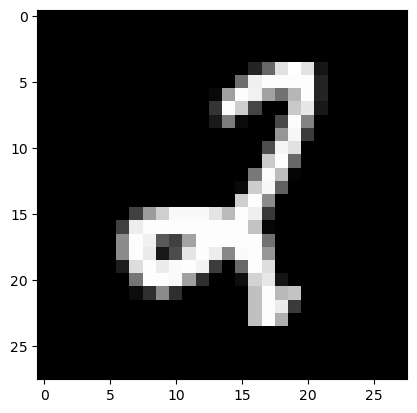

In [306]:
plt.imshow(img[0].squeeze(), cmap='gray')
target[0]

In [334]:
img.shape

torch.Size([64, 1, 28, 28])

In [354]:
ss = torch.tensor([[[
    [-0.16466, -0.068212, 0],
    [0, 0.187472, 0.374204],
    [0, 0, 0.341797]
]]])

ss.shape

torch.Size([1, 1, 3, 3])

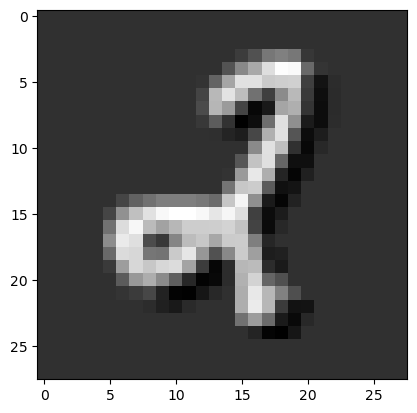

In [355]:
res = F.conv2d(input=img[0],
               # weight=torch.tensor(weights[0, 3][np.newaxis][np.newaxis]),
               weight=ss,
               bias=torch.tensor(bias[0][np.newaxis]),
               stride=1,
               padding='same')
plt.imshow(res.squeeze(), cmap='gray')

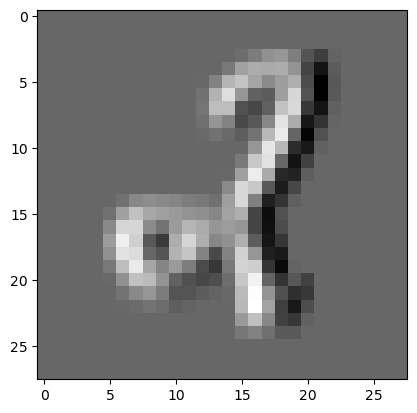

In [381]:
res = F.conv2d(input=img[0],
               weight=torch.tensor(weights[0, 3][np.newaxis][np.newaxis]),
               # weight=ss,
               bias=torch.tensor(bias[0][np.newaxis]),
               stride=1,
               padding='same')
plt.imshow(res.squeeze(), cmap='gray')